# Assignment 2 – Zero-Shot Image Classification with Transformers

In this assignment, you will apply a pre-trained vision–language transformer (e.g. CLIP) to perform **zero-shot** classification on the Fashion-MNIST dataset—classifying each image without any task-specific training. You will build on the concepts from Assignment 1 by comparing this “off-the-shelf” approach to the CNN you previously trained.

You will:
1. **Load** the Fashion-MNIST images using PyTorch instead of Keras.
2. **Run a zero-shot baseline** with simple text prompts to set a performance reference.
3. **Engineer improved prompts** and measure the resulting accuracy gains.
4. **Visualise image embeddings** with UMAP to inspect class separability.
5. **Conduct one mini-experiment** of your choice.
6. **Summarise findings** and reflect on strengths and weaknesses of zero-shot transformers versus a trained CNN.

# 1. Loading the Fashion-MNIST Dataset

As in assignment 1, we'll load the Fashion-MNIST dataset, but this time using `torchvision.datasets` to ensure compatibility with the `transformers` library. We will also load our model and processor from the `transformers` library.

The transformers library allows us to use pre-trained models like CLIP, which can perform zero-shot classification by leveraging the text prompts we provide. There are two key objects we will use: the `CLIPModel` for the model itself and the `CLIPProcessor` for preparing our images and text prompts.

Since we are not actually training a model in this assignment, we will set the CLIP model to evaluation mode. If the model is designed to utilize features like dropout or batch normalization, setting it to evaluation mode ensures that these features behave correctly during inference (prediction). Setting the model to evaluaton mode also tells PyTorch that we don't have to compute gradients, which can save memory and speed up inference.

In order to speed up processing, we will also move the model to an "accelerator" if available. This is typically a GPU, but modern MacBooks also have an "Apple Silicon" accelerator that can be used for inference, called MPS (Metal Performance Shaders). If you are using a MacBook with Apple Silicon, you can use the MPS device for faster processing.

In [ ]:
# Uncomment and run if required
#!pip install transformers torchvision torch accelerate

In [29]:
from transformers import CLIPModel, CLIPProcessor
import torch

clip_model_name = "openai/clip-vit-base-patch32"
clip_model     = CLIPModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name, use_fast=False)

# Set model to evaluation mode, as we are not training it
clip_model.eval()

# Check for accelerators
device = "cpu" # Default to CPU
if torch.cuda.is_available():
    device = "cuda" # Use GPU if available
elif torch.backends.mps.is_available():
    device = "mps"

clip_model.to(device)

print(f"Using device: {device}")

Using device: mps


Now we are ready to load the testing set from Fashion-MNIST. We will use the `torchvision.datasets.FashionMNIST` class to load the dataset. We do not need to apply any transformations to the images, as the `CLIPProcessor` ensures any input images are in the format that the model is trained on.

You should:

- [ ] Use the `torchvision.datasets.FashionMNIST` class to load the *test* split of the dataset. Documentation is available [here](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).
- [ ] Create a PyTorch `DataLoader` to iterate over the dataset in batches. Use a batch size of 16 and set `shuffle=True` to randomise the order of the images. You will also need to supply the provided `collate_clip` function to the `DataLoader collate_fn` argument to ensure the images are processed correctly. Documentation for `DataLoader` is available [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

In [30]:
from torchvision import datasets
from torch.utils.data import DataLoader

CLASS_NAMES = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

def collate_clip(batch):
    imgs, labels = zip(*batch) # Unzip the batch into images and labels
    proc = clip_processor(images=list(imgs),
                        return_tensors="pt",
                        padding=True) # Process images with CLIPProcessor
    # Send pixel_values to GPU/CPU now; labels stay on CPU for metrics
    return proc["pixel_values"].to(device), torch.tensor(labels)

test_dataset = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_clip
)

If your code is correct, the following cell should show the first batch of images from the Fashion-MNIST dataset:

Unused or unrecognized kwargs: padding.


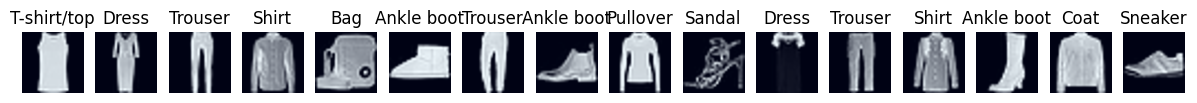

In [31]:
import matplotlib.pyplot as plt

# Display the first batch of images from `test_loader`

def show_batch(loader):
    images, labels = next(iter(loader))
    images = images.cpu()  # Move images to CPU for plotting
    # Renormalize to [0, 1] for visualization
    images = (images - images.min()) / (images.max() - images.min())
    _, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img, label in zip(axes, images, labels):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(CLASS_NAMES[label.item()])
        ax.axis('off')
    plt.show()

show_batch(test_loader)

We’re now ready to run our zero-shot classification baseline!

# Brief Introduction to Zero-Shot Classification

In Assignment 1, we followed the typical machine-learning pipeline: we trained a CNN on the Fashion-MNIST dataset, using labelled examples to update the model’s weights. While effective, that approach requires a curated, task-specific training set—a luxury you don’t always have in practice.

Zero-shot classification flips the script.  A large vision–language model (VLM) such as **CLIP** is first pre-trained on hundreds of millions of image–text pairs scraped from the web.  Because it learns *joint* visual–textual embeddings, the model can later solve new tasks simply by “measuring” how similar an image is to a **text prompt** that describes each candidate class—without seeing a single task-labelled example.

**How it works**  
1. Feed an image through CLIP’s vision encoder → **image feature**.  
2. Feed a textual prompt (e.g. “a photo of a sandal”) through CLIP’s text encoder → **text feature**.  
3. Compute cosine similarity between the image feature and every class’s text feature.  
4. Pick the class whose prompt is most similar.

For our first attempt, we’ll use the bare class names as prompts, e.g.:

- "T-shirt/top"
- "Trouser"

### You should:

- [ ] Build embeddings: use the `get_text_embeddings` helper function to create text embeddings for the class names.
- [ ] Run inference: use the `get_image_embeddings` helper function to create image embeddings.
- [ ] Compute cosine similarity: complete and use the `get_cosine_similarity` helper function to compute the cosine similarity between the image and text embeddings.
- [ ] Make predictions: use the `get_predictions` helper function to get the predicted class for each image in the batch.

Note that for normalized vectors like the ones we are using, cosine similarity is equivalent to the dot product. This means we can use the handy formula `cosine_similarity = vector_a @ vector_b.T` to compute the similarity between the image and text embeddings.

In [32]:
def get_text_embeddings(class_names: list[str]) -> torch.Tensor:
    """    Get text embeddings for the given class names using CLIP.
    Args:
        class_names (list[str]): List of class names to encode.
    Returns:
        torch.Tensor: Normalized text embeddings for the class names.
    """
    tokenized = clip_processor(text=class_names,
                               padding=True,
                               return_tensors="pt").to(device)
    
    with torch.no_grad(): # no training, no need to use gradients
        text_embeddings = clip_model.get_text_features(**tokenized)

    text_feats = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

    return text_feats

def get_image_embeddings(images: torch.Tensor) -> torch.Tensor:
    """    Get image embeddings for the given images using CLIP.
    Args:
        images (torch.Tensor): Batch of images to encode.
    Returns:
        torch.Tensor: Normalized image embeddings for the images.
    """
    with torch.no_grad():
        image_embeddings = clip_model.get_image_features(pixel_values=images)

    image_feats = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)

    return image_feats

In [33]:
import numpy as np

def get_cosine_similarity(image_feats: torch.Tensor, text_feats: torch.Tensor) -> np.ndarray:
    """
    Compute cosine similarity between image features and text features.
    Args:
        image_feats (torch.Tensor): Image features of shape (N, D).
        text_feats (torch.Tensor): Text features of shape (M, D).
    Returns:
        numpy.ndarray: Cosine similarity matrix of shape (N, M), where N is the number of images and M is the number of text prompts.
    """
    image_feats = image_feats.cpu()  # Ensure image features are on CPU
    text_feats = text_feats.cpu()    # Ensure text features are on CPU

    # Compute cosine similarity, which is the dot product of normalized vectors
    similarity = image_feats @ text_feats.T
    return similarity.numpy() # Complete

def get_predictions(similarity: np.ndarray) -> np.ndarray:
    """
    Get predictions based on cosine similarity scores.
    Args:
        similarity (numpy.ndarray): Cosine similarity matrix of shape (N, M), where N is the number of images and M is the number of text prompts.
    Returns:
        numpy.ndarray: Predicted class indices for each image, shape (N,).
    """
    # Get the index of the maximum similarity for each image
    return np.argmax(similarity, axis=1) # Complete

With these functions complete, you are ready to run the zero-shot classification baseline. Complete the code to follow these steps:

- [ ] Build text embeddings for the class names using the `get_text_embeddings` function (this only needs to be done once).
- [ ] For each batch of images:
    - [ ] Get image embeddings using the `get_image_embeddings` function.
    - [ ] Compute cosine similarity between the image and text embeddings using the `get_cosine_similarity` function.
    - [ ] Save the predictions so that we can build a confusion matrix later.
- [ ] Report the accuracy of the predictions and the confusion matrix using the `accuracy_score` and `confusion_matrix` functions from `sklearn.metrics`.

In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix

# here we ran the baseline model.

text_feats = get_text_embeddings(CLASS_NAMES)

y_true, y_pred = [], []

for pixel_values, labels in test_loader:
    pixel_values = pixel_values.to(device)
    image_feats = get_image_embeddings(pixel_values)
    sim = get_cosine_similarity(image_feats, text_feats)
    preds = get_predictions(sim)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Report the accuracy of the predictions
acc = accuracy_score(y_true, y_pred)
print(f'accuracy: {acc:.4f}')

# Report the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# this is for 10 classes
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


accuracy: 0.6240
Confusion Matrix:
 [[769  25   2  95  18  14  19   0  58   0]
 [  0 931   0   5   5  56   0   0   3   0]
 [415  25 306   6 174   7   4   0  63   0]
 [ 56  87   2 504 216  77   2   1  53   2]
 [ 74  19 143   9 690   6   1   0  58   0]
 [  0  31   3   0   1 393   0 414  17 141]
 [338  29  29  79 394  20  42   0  68   1]
 [  0   0   0   0   0  49   0 950   0   1]
 [  0  14   3   0   1  19   0   5 958   0]
 [  0   0   0   0   0   5   0 297   1 697]]


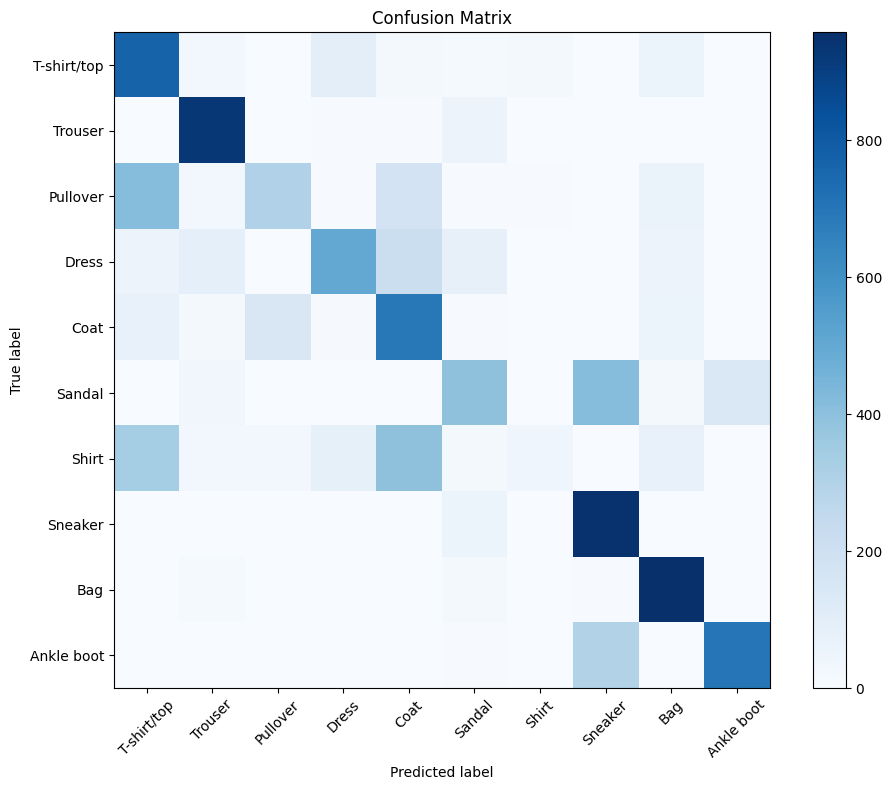

In [35]:
plot_confusion_matrix(y_true, y_pred, CLASS_NAMES)

Reflection: Consider the results. How does the performance of this zero-shot baseline compare to the CNN you trained in Assignment 1? What are the strengths and weaknesses of this approach?

- baseline accuracy at 62.4% is materially worse than the CNN we trained in Assignment 1 (around ~90–91% there).

CNN:
- trained directly on your dataset labels
- earns dataset-specific cues (style, backgrounds, class boundaries)

Zero-shot CLIP:
- matching image embeddings to text prompt embeddings (e.g., “cat”, “truck”) with no training on your dataset.
- if the dataset’s visual style or label semantics don’t align with CLIP’s pretraining distribution or your prompt wording, accuracy drops

## Improving Zero-Shot Classification with Prompt Engineering

In the previous section, we directly used the class names as text prompts for zero-shot classification. However, we can often improve performance by crafting more descriptive prompts that better capture the visual characteristics of each class. For example, instead of just "T-shirt/top", we could use "a photo of a T-shirt" or "a photo of a top". This additional context can help the model make more accurate predictions.

In this section, we will experiment with more detailed prompts for each class to see if we can improve the zero-shot classification performance. You should:

- [ ] Create a list of improved prompts for each class. For example, instead of just "T-shirt/top", you could use "a photo of a T-shirt" or "a photo of a top".
- [ ] Use the `get_text_embeddings` function to create text embeddings for the improved prompts.
- [ ] Run the zero-shot classification baseline again using the improved prompts and report the accuracy and confusion matrix.

Note: Take advantage of the confusion matrix above. If two classes are often confused, consider how you might improve the prompts to help the model distinguish them better.

The aim for this section is for you to improve the performance of the model. However, if you find that the performance does not improve significantly, you can still reflect on the process and consider how you might further refine the prompts with more effort.

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix

# here we run baseline model with detailed prompts for each class.

CLASS_NAMES_improved = [
    "a low-res greyscale photo of a T-shirt",
    "a low-res greyscale photo of a Trouser",
    "a low-res greyscale photo of a Pullover",
    "a low-res greyscale photo of a Dress",
    "a low-res greyscale photo of a Coat",
    "a low-res greyscale photo of a Sandal",
    "a low-res greyscale photo of a Shirt",
    "a low-res greyscale photo of a Sneaker",
    "a low-res greyscale photo of a Bag",
    "a low-res greyscale photo of a Ankle boot"
]

text_feats = get_text_embeddings(CLASS_NAMES_improved)

y_true, y_pred = [], []

for pixel_values, labels in test_loader:
    pixel_values = pixel_values.to(device)
    image_feats = get_image_embeddings(pixel_values)
    sim = get_cosine_similarity(image_feats, text_feats)
    preds = get_predictions(sim)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Report the accuracy of the predictions
acc = accuracy_score(y_true, y_pred)
print(f'accuracy: {acc:.4f}')

# Report the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


accuracy: 0.6825
Confusion Matrix:
 [[544  16  97 214   6   6  27   0  90   0]
 [  0 944   0  15   3  30   0   0   8   0]
 [  3   1 872  14  34   2   0   0  74   0]
 [  6  29  23 709  86  45   0   0 102   0]
 [  1   6 567  42 305   5   0   0  74   0]
 [  0  46   0   0   1 742   0  44  99  68]
 [ 63  16 415 170 189  14  30   0 103   0]
 [  0   0   0   0   0 183   0 792   3  22]
 [  0   0   1   0   0   4   0   0 995   0]
 [  0   0   0   0   0  17   0  89   2 892]]


Reflection: 
- How did your detailed prompts affect the zero-shot classification performance? 
    - the prompt improved accuracy from 62.4 to 68.25, this gain is due to detailed description of what our photos are.
- Did you see a significant improvement compared to the baseline? 
    - Yes. Accuracy moved from 0.6240 → 0.6825.
- What insights did you gain about the model's understanding of the classes? 
    - It understands some classes extremely well, and others poorly, the pretrained concept space matches some labels much better than others.
- Do you think that with more effort you could further improve the performance? If so, how?
    - maybe could be more descriptive in prompt, like adding multiple descriptions. ex. low-res, centered, blurry picture.

## Visualizing Image Embeddings with UMAP

To better understand how the model perceives the different classes, we can visualize the image embeddings using UMAP (Uniform Manifold Approximation and Projection). UMAP is a dimensionality reduction technique that helps us see how similar or dissimilar the embeddings are in a lower-dimensional space.

By visualizing the embeddings, we can gain insights into how well the model can distinguish certain images, even without considering the text prompts. This can help us identify clusters of similar images and see if there are any overlaps between classes.

You should:

- [ ] Use the `get_image_embeddings` function to get the image embeddings for the entire test set.
- [ ] Use UMAP to reduce the dimensionality of the image embeddings to 2D.
- [ ] Plot the 2D embeddings, coloring each point by its true class label.

You may need to install the `umap-learn` library if you haven't already. You can do this by running `pip install umap-learn`.

In [ ]:
# Uncomment the following line to install UMAP if you haven't already
# !pip install umap-learn

Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


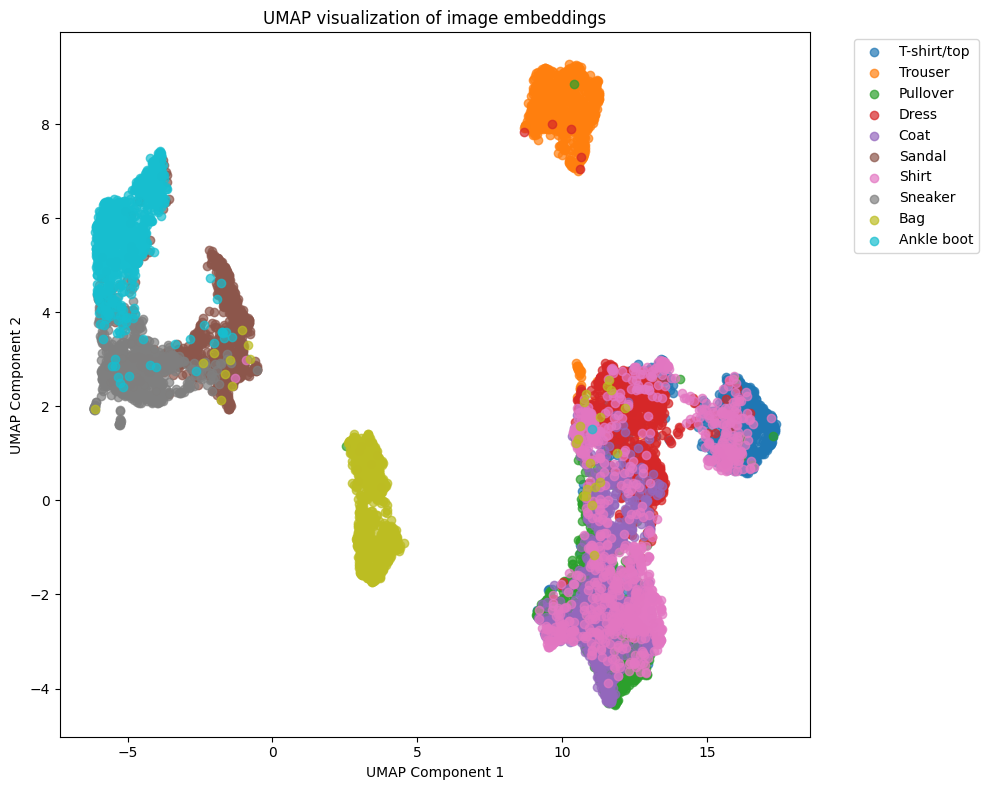

In [12]:
from umap import UMAP

# ------------------------------------------------------------
# 1. Collect image embeddings
# ------------------------------------------------------------
all_img_emb = []
all_labels  = []

for pixel_values, labels in test_loader:
    image_feats = get_image_embeddings(pixel_values)
    all_img_emb.extend(image_feats.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

all_img_emb = np.array(all_img_emb)
all_labels = np.array(all_labels)

# ------------------------------------------------------------
# 2. Fit UMAP
# ------------------------------------------------------------

umap = UMAP(n_components=2, random_state=42)
img_emb_2d = umap.fit_transform(all_img_emb)

# ------------------------------------------------------------
# 3. Plot coloured by ground-truth label
# ------------------------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for i, label in enumerate(CLASS_NAMES):
    indices = np.where(all_labels == i)[0]
    plt.scatter(img_emb_2d[indices, 0], img_emb_2d[indices, 1], label=label, alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("UMAP visualization of image embeddings")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.tight_layout()
plt.show()

The UMAP embeddings allow us to see how separable or non-separable different classes are with our specific model. If two specific images are very similar, then they will be placed near each other on this graph. 

Reflection: 
- Do you notice any challenges in distinguishing images based on this figure? 
  - T-shirt/top, Coat, Shirt, Dress are largely sitting in the same right-hand region with lots of mixing.
- Are there any types of clothing in the dataset which the model has no trouble distinguishing from the others?
  - Trouser and Bag are seperated nicely.

## Mini-Experiment

In this section, you will conduct a mini-experiment of your choice to further explore the capabilities of zero-shot classification with transformers. This can be anything you'd like, but here are some ideas to get you started.

### A. Alternative Model

So far we have been utilizing OpenAI's CLIP model for zero-shot classification. However, there are many other vision–language models available in the `transformers` library that you can experiment with. For example, there are larger CLIP models such as [clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14), and open-source versions such as [laion/CLIP-ViT-B-32-laion2B-s34B-b79K](https://huggingface.co/laion/CLIP-ViT-B-32-laion2B-s34B-b79K). You can also search huggingface [here](https://huggingface.co/models?sort=trending&search=clip) to find other models that might be suitable for zero-shot classification.

You can try using a different model to see if it improves the zero-shot classification performance. You should:
- [ ] Load a different model and processor from the `transformers` library.
- [ ] Run the zero-shot classification baseline with the new model and report the accuracy and confusion matrix.
- [ ] Reflect on the performance of the new model compared to the original CLIP model
  - How does the new model perform compared to the original CLIP model?
  - Do you notice any differences in the types of errors made by the new model?

### B. Multiple-Description Classification

Another interesting experiment is to explore multiple-description classification. *This involves providing multiple text prompts for each class, allowing the model to choose the most relevant one. For example, instead of just "T-shirt/top", you could provide "a photo of a T-shirt", "a photo of a top", and "a photo of a shirt". This can help the model better understand the class and increases the likelihood of a correct prediction. You should:

- [ ] Create a list of multiple prompts for each class.
- [ ] Use the `get_text_embeddings` function to create text embeddings for the multiple prompts.
- [ ] Run the zero-shot classification baseline again using the multiple prompts and report the accuracy and confusion matrix.
- [ ] Consider the model to be correct if it guesses *any* of the prompts belonging to the correct class.

### C. Top-K Classification

In some classification tasks, it can be useful to consider if the right answer is among the top K (e.g. top 3) predictions. This can be particularly useful in cases where the model is uncertain or when there are multiple similar classes. You should:

- [ ] Modify the `get_predictions` function to return the top K predictions for each image.
- [ ] Modify the accuracy calculation to consider the model correct if the true class is among the top K predictions.
- [ ] Report the accuracy and confusion matrix for the top K predictions. Report at least two different values of K (e.g. K=2 and K=4).

### D. Other Ideas

You are welcome to come up with your own mini-experiment! Explain your idea in the report and implement it. Did it work as you expected? What did you learn from it?

In [37]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def run_zero_shot(test_loader, text_feats, device):
    y_true, y_pred = [], []

    for pixel_values, labels in test_loader:
        pixel_values = pixel_values.to(device) # this uses the model on the device
        image_feats = get_image_embeddings(pixel_values)
        sim = get_cosine_similarity(image_feats, text_feats)
        preds = get_predictions(sim)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

    return np.array(y_true), np.array(y_pred)

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

def report_results(y_true, y_pred, class_names, title=""):
    acc = accuracy_score(y_true, y_pred)
    print(f"{title} Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    plot_confusion_matrix(y_true, y_pred, class_names, title=title or "Confusion Matrix")
    return acc

## A: Using an alternative model:

In [38]:
from transformers import CLIPModel, CLIPProcessor
import torch

NEW_MODEL_ID = "openai/clip-vit-large-patch14" # this is the larger model
# NEW_MODEL_ID = "openai/clip-vit-base-patch32" # this is the baseline model we used before.
# NEW_MODEL_ID = "laion/CLIP-ViT-B-32-laion2B-s34B-b79K"

clip_model = CLIPModel.from_pretrained(NEW_MODEL_ID).to(device) # this will download and load the new model to device, which was setup earlier.
clip_processor = CLIPProcessor.from_pretrained(NEW_MODEL_ID)
clip_model.eval()
print("Loaded:", NEW_MODEL_ID)

/Users/haichenzhang/dev/DSI_learning/deep_learning/deep-learning-env/lib/python3.11/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded: openai/clip-vit-large-patch14


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Zero-shot (openai/clip-vit-large-patch14) Accuracy: 0.6775
Confusion Matrix:
 [[537   3  42 291   3  21  95   1   4   3]
 [  0 977   0  19   0   4   0   0   0   0]
 [  8  11 818  76  23  33   6   0  25   0]
 [  2  22   7 862  37  60   0   0   2   8]
 [  0   4 359  78 497  12  34   1  15   0]
 [  0  28   5   0   1 477   0 119  10 360]
 [ 63  24 284 251 212  20 134   0   9   3]
 [  0   2   0   0   0 151   0 769   0  78]
 [  0  79   1   7   3 118   0   7 762  23]
 [  0   0   0   0   0  10   0  48   0 942]]


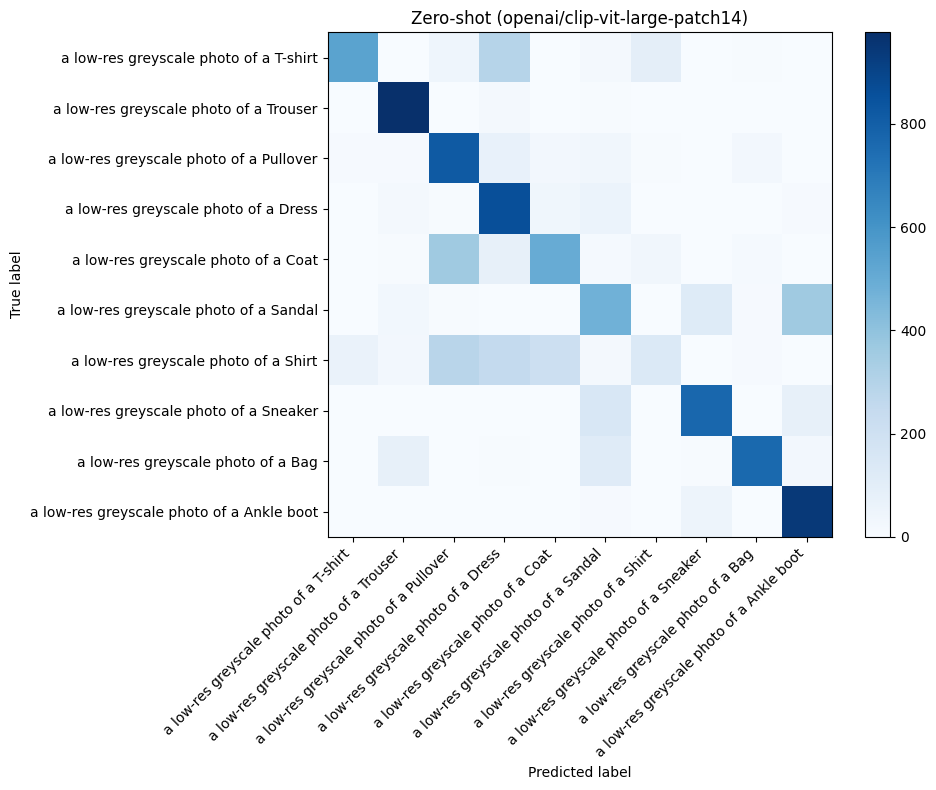

In [39]:
# we are using detailed prompts with the new model

text_feats = get_text_embeddings(CLASS_NAMES_improved)

y_true, y_pred = run_zero_shot(test_loader, text_feats, device)
acc_new = report_results(y_true, y_pred, CLASS_NAMES_improved, title=f"Zero-shot ({NEW_MODEL_ID})")

## B: Multiple Prompts:

In [40]:
# here we provide multiple description for each class
prompt_extended = {
    "T-shirt/top": [
        "a low-res greyscale photo of a t-shirt",
        "a low-res greyscale photo of a top",
        "a low-res greyscale photo of a short sleeve shirt",
    ],
    "Trouser": [
        "a low-res greyscale photo of trousers",
        "a low-res greyscale photo of pants",
        "a low-res greyscale photo of long pants",
    ],
    "Pullover": [
        "a low-res greyscale photo of a pullover",
        "a low-res greyscale photo of a sweater",
        "a low-res greyscale photo of a sweatshirt",
    ],
    "Dress": [
        "a low-res greyscale photo of a dress",
        "a low-res greyscale photo of a one-piece dress",
        "a low-res greyscale photo of a gown",
    ],
    "Coat": [
        "a low-res greyscale photo of a coat",
        "a low-res greyscale photo of an overcoat",
        "a low-res greyscale photo of a jacket coat",
    ],
    "Sandal": [
        "a low-res greyscale photo of sandals",
        "a low-res greyscale photo of open-toe footwear",
        "a low-res greyscale photo of a sandal",
    ],
    "Shirt": [
        "a low-res greyscale photo of a shirt",
        "a low-res greyscale photo of a button shirt",
        "a low-res greyscale photo of a long sleeve shirt",
    ],
    "Sneaker": [
        "a low-res greyscale photo of sneakers",
        "a low-res greyscale photo of athletic shoes",
        "a low-res greyscale photo of running shoes",
    ],
    "Bag": [
        "a low-res greyscale photo of a bag",
        "a low-res greyscale photo of a handbag",
        "a low-res greyscale photo of a backpack",
    ],
    "Ankle boot": [
        "a low-res greyscale photo of ankle boots",
        "a low-res greyscale photo of a boot",
        "a low-res greyscale photo of short boots",
    ],
}

In [44]:
# now we switch back to baseline model to see if multiple prompt can help with baseline model.

#NEW_MODEL_ID = "openai/clip-vit-large-patch14"
NEW_MODEL_ID = "openai/clip-vit-base-patch32" 
# NEW_MODEL_ID = "laion/CLIP-ViT-B-32-laion2B-s34B-b79K"

clip_model = CLIPModel.from_pretrained(NEW_MODEL_ID).to(device)

print(clip_model.config._name_or_path)

openai/clip-vit-base-patch32


In [45]:
all_prompts = []
prompt_to_class = []  # integer class index for each prompt

name_to_idx = {name: i for i, name in enumerate(CLASS_NAMES)}

for cls_name, prompts in prompt_extended.items():
    cls_idx = name_to_idx[cls_name]
    for p in prompts:
        all_prompts.append(p)
        prompt_to_class.append(cls_idx)

prompt_to_class = np.array(prompt_to_class)  # shape (P,)
text_feats_all = get_text_embeddings(all_prompts)  # shape (P, D)

Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Zero-shot Multi-Prompt (max) Accuracy: 0.6469
Confusion Matrix:
 [[623   1  53 194  17   5  55   0  50   2]
 [  0 802   4  32  36 101   0   0   1  24]
 [  5   1 848  25  47   2  13   0  59   0]
 [ 10   8  19 698 193  11   4   0  27  30]
 [  3   0 458  38 399   2  45   0  54   1]
 [  1   0   0   0   4 389   0 375   9 222]
 [ 83   4 296 159 203   6 178   0  71   0]
 [  0   0   0   0   0  69   0 917   0  14]
 [  0   0   0   0   0   2   3   2 971  22]
 [  1   0   0   0   0 132   0 223   0 644]]


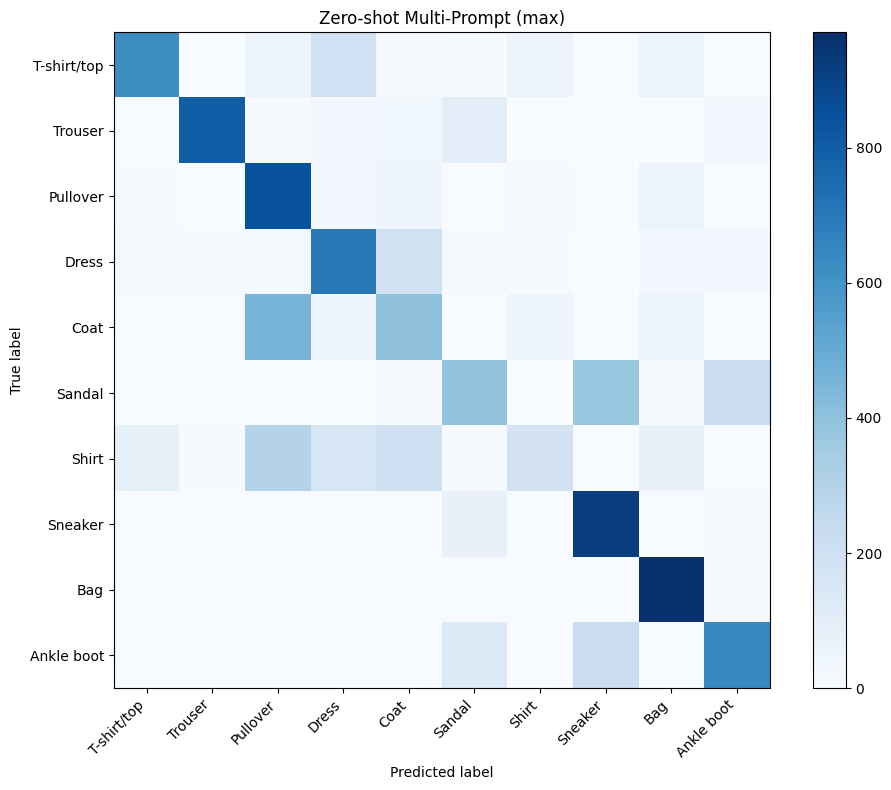

In [46]:
def predict_with_prompt_aggregation(test_loader, text_feats_all, prompt_to_class, num_classes, agg="max"):
    y_true, y_pred = [], []

    for pixel_values, labels in test_loader:
        pixel_values = pixel_values.to(device) # this uses the same device as the model
        # openai/clip-vit-large-patch14
        image_feats = get_image_embeddings(pixel_values)  # (B, D)
        sim = get_cosine_similarity(image_feats, text_feats_all)  # (B, P)

        # Aggregate prompt sims into class sims: (B, num_classes)
        class_scores = np.full((sim.shape[0], num_classes), -np.inf, dtype=np.float32)

        if agg == "max":
            for c in range(num_classes):
                class_scores[:, c] = sim[:, prompt_to_class == c].max(axis=1)
        elif agg == "mean":
            for c in range(num_classes):
                class_scores[:, c] = sim[:, prompt_to_class == c].mean(axis=1)
        else:
            raise ValueError("agg must be 'max' or 'mean'")

        preds = np.argmax(class_scores, axis=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

    return np.array(y_true), np.array(y_pred)

y_true, y_pred = predict_with_prompt_aggregation(
    test_loader, text_feats_all, prompt_to_class, num_classes=len(CLASS_NAMES), agg="max"
)
acc_multi = report_results(y_true, y_pred, CLASS_NAMES, title="Zero-shot Multi-Prompt (max)")

## D: A mix of larger Model with Multiple prompts:

In [47]:
# now we switch to use larger model. Note we are using the same multiple prompts.

NEW_MODEL_ID = "openai/clip-vit-large-patch14"
#NEW_MODEL_ID = "openai/clip-vit-base-patch32" 
# NEW_MODEL_ID = "laion/CLIP-ViT-B-32-laion2B-s34B-b79K"

clip_model = CLIPModel.from_pretrained(NEW_MODEL_ID).to(device)

print(clip_model.config._name_or_path)

/Users/haichenzhang/dev/DSI_learning/deep_learning/deep-learning-env/lib/python3.11/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


openai/clip-vit-large-patch14


In [48]:
all_prompts = []
prompt_to_class = []  # integer class index for each prompt

name_to_idx = {name: i for i, name in enumerate(CLASS_NAMES)}

for cls_name, prompts in prompt_extended.items():
    cls_idx = name_to_idx[cls_name]
    for p in prompts:
        all_prompts.append(p)
        prompt_to_class.append(cls_idx)

prompt_to_class = np.array(prompt_to_class)  # shape (P,)
text_feats_all = get_text_embeddings(all_prompts)  # shape (P, D)

Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Zero-shot Multi-Prompt (max) Accuracy: 0.7212
Confusion Matrix:
 [[600   4  22 284   0  11  62   3  10   4]
 [  0 941   0  50   1   6   0   0   0   2]
 [  9   2 744  79  19  13  49   1  84   0]
 [  1   7   5 916  26  33   2   1   6   3]
 [  1   0 242 124 510   4  92   0  25   2]
 [  0  12   0   1   2 636   0 285  34  30]
 [ 98  10 175 265 174   8 236   2  31   1]
 [  0   1   0   0   0  51   0 930   0  18]
 [  4  22   0  11   2  66   2  28 856   9]
 [  0   1   0   0   0  17   0 139   0 843]]


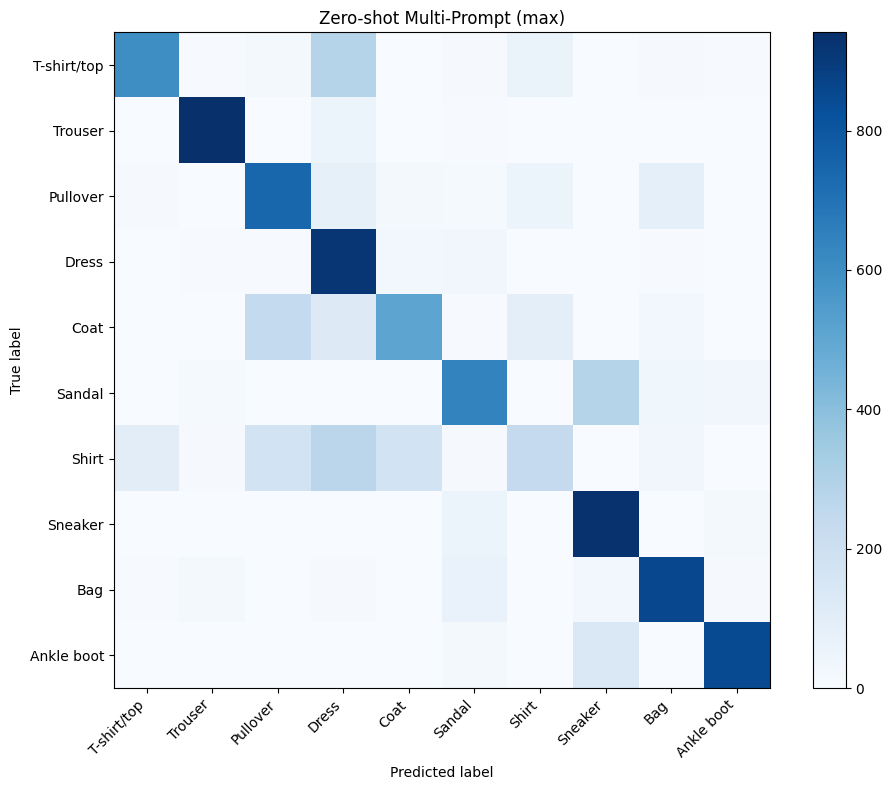

In [49]:
def predict_with_prompt_aggregation(test_loader, text_feats_all, prompt_to_class, num_classes, agg="max"):
    y_true, y_pred = [], []

    for pixel_values, labels in test_loader:
        pixel_values = pixel_values.to(device) # this uses the same device as the model
        # openai/clip-vit-large-patch14
        image_feats = get_image_embeddings(pixel_values)  # (B, D)
        sim = get_cosine_similarity(image_feats, text_feats_all)  # (B, P)

        # Aggregate prompt sims into class sims: (B, num_classes)
        class_scores = np.full((sim.shape[0], num_classes), -np.inf, dtype=np.float32)

        if agg == "max":
            for c in range(num_classes):
                class_scores[:, c] = sim[:, prompt_to_class == c].max(axis=1)
        elif agg == "mean":
            for c in range(num_classes):
                class_scores[:, c] = sim[:, prompt_to_class == c].mean(axis=1)
        else:
            raise ValueError("agg must be 'max' or 'mean'")

        preds = np.argmax(class_scores, axis=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

    return np.array(y_true), np.array(y_pred)

y_true, y_pred = predict_with_prompt_aggregation(
    test_loader, text_feats_all, prompt_to_class, num_classes=len(CLASS_NAMES), agg="max"
)
acc_multi = report_results(y_true, y_pred, CLASS_NAMES, title="Zero-shot Multi-Prompt (max)")

## Short Report

In this section, you will write a short report summarizing your findings from the mini-experiment. The report should include the following sections:

- **Introduction**: Briefly describe the mini-experiment you conducted and its objectives.
- **Methodology**: Explain the steps you took to conduct the experiment, including any modifications you made to the code or model.
- **Results**: Present the results of your experiment.
- **Discussion**: Reflect on the performance of the model and the implications of your findings. Consider the strengths and weaknesses of zero-shot transformers versus a trained CNN.

Introduction

In this mini-experiment, I explored whether zero-shot image classification with CLIP can be improved:

- (i) by using a larger vision-language model and 
- (ii) by improving the text prompts used for each class. 

The objective was to evaluate how much performance can be gained without any task-specific training, and to compare these approaches against the baseline CLIP model. 

Methodology

I ran three experiments on the same Fashion-MNIST test set and evaluation pipeline (accuracy + confusion matrix):

- A: Alternative Model (using a larger CLIP)
	- Swapped the model from the default CLIP to openai/clip-vit-large-patch14 using Hugging Face transformers.
	- Kept the rest of the zero-shot pipeline the same: 
		- compute text embeddings once, 
		- compute image embeddings per batch, 
		- then use cosine similarity + argmax for prediction.
	- Used the same prompt style as the improved baseline (more descriptive prompt rather than raw class name).

- B: Multiple-Description (prompt Engineering)
	- For each class, created multiple natural language prompts (synonyms + phrasing variants) designed to better match dataset characteristics.
	- Computed embeddings for all prompts, then aggregated per class using max similarity (“a class is correct if any of its prompts match strongly”).
	- Ran the same inference loop, but replaced single-prompt scoring with max-over-prompts scoring per class.

- D: Larger model + Multiple Description Prompts.
	- Use larger model with multiple descriptive prompts for each class.
	- Same pipeline for text and image embedding.
	- Max similarity is carried over to handle for multiple prompts, where a class is correct if any of its prompts match strongly.

Results

- Experiment A — Larger CLIP model + Detail prompt
	- Accuracy: 0.6775
	- Key pattern in the confusion matrix: strong performance on some classes 
		- (e.g., Trouser 977 correct and Ankle boot 942 correct), 
	- Still persistent confusion among visually similar upper-body garments (e.g., shirt/top/coat/dress). 
	- Footwear also shows cross-confusion (e.g., Ankle boot vs Sandal).

- Experiment B — Baseline CLIP model + Multi-prompt
	- Accuracy: 0.6469
	- Multiple prompts did not improve Baseline model accuracy as much as Detail Class Names (0.6825). The confusion matrix showed confusion for several categories, and the “look-alike” classes remain the main source of error.

- Experiment D — Larger CLIP model + Multi-prompt
	- Accuracy: 0.7212
	- This is the best of the mini-experiments. The confusion matrix shows reduced confusion for several categories and stronger diagonal mass overall, while the “look-alike” classes still remain the main source of error.

Relative comparison:

- Baseline with Class Name only, accuracy: 0.6240
- Baseline with Detailed Class Name, accuracy: 0.6825
- Baseline with Multi-prompt Class Name, accuracy: 0.6469
- Large CLIP model with Detailed Class Name, accuracy: 0.6775
- Large CLIP model with Multi-prompt Class Name, accuracy: 0.7212

Key Findings:

- Prompt engineering: (Detailed Class Name vs Multi-prompts Class Name)
	- Multi-prompt improved accuracy by ~4.37 percentage points over the larger model (0.7212 − 0.6775).
	- Multi-prompt DID NOT improve accuracy over the baseline model (0.6469 − 0.6825).

- Model Size:
	- When both using Detailed Class Name, the larger model underperformed the baseline model (0.6775 vs 0.6825).
	- When both using Multi-prompt, the larger model significantly overperformed the baseline model (0.7212 vs 0.6469). 

Discussion

1.	Prompting matters but not always.
Moving from class names only to detailed prompts improved performance meaningfully (0.6240 → 0.6825, +5.85 pts). That’s strong evidence the baseline prompt (“item name”) was under-specifying the data distribution. Adding “low-res greyscale photo of …” better matches the Fashion-MNIST domain and helps CLIP choose the right concept space. However, multi-prompt prompting behaved differently across model sizes:
	- Large model: multi-prompt helped (0.6775 → 0.7212, +4.37 pts).
	- Base model: multi-prompt hurt relative to detailed single prompt (0.6825 → 0.6469, −3.56 pts).


2. Model size: not always better, unless paired with the right prompting
With detailed single prompts, the large model slightly underperformed the base model (0.6775 vs 0.6825). But with multi-prompt, the large model strongly outperformed the base model (0.7212 vs 0.6469).

	- The large model’s advantage shows up when the input prompt distribution is more complex (multiple descriptions). It can better “average out” or handle variability in language, and it finds stronger matches when any prompt is a good fit.
	- When the prompting is already “clean” and simple (one strong prompt), the large model doesn’t necessarily improve and may even be slightly worse due to differences in how it embeds and ranks borderline classes in this dataset. 

Overall takeaway

Zero-shot CLIP provides a strong, flexible baseline and can be meaningfully improved with prompt engineering. However, for Fashion-MNIST, a trained CNN still dominates because it learns the specific visual boundaries required for fine-grained clothing distinctions. 

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.
### Submission Parameters:
* Submission Due Date: `23:59 PM - 02/11/2025`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb)
    * The Lab 4 notebook (labs/lab_4.ipynb)
    * The Lab 5 notebook (labs/lab_5.ipynb)
    * The Lab 6 notebook (labs/lab_6.ipynb)
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
* Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.
Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.
If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-7-help-ml`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.